Calculating Energy Efficiency for an IRS-Assisted Wireless Network.
1. Using a 3D environment to model Base Station, IRS and Users.
2. Implementing on a 2 User system.
3. Starting with a Double-IRS Assisted Network, comparing energy efficiency for both Ideal and Practical Models.
4. Shifting to a Single IRS Assisted Network and comparing energy efficiency for both Ideal and Practical Models.
5. We have performed the comparison keeping in mind all three quantization bits, and considering element sharing to be true for all scenarios. 

In [9]:
# Importing all libraries

import numpy as np 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from Functions import *

In [10]:
#============== System parameters
'''
Defining Parameters
    Nt = Number of transmit antennas (SISO = 1)
    K = Number of Users
    BW = Bandwidth
    NF = Noise Floor
    ALPHA = PLE for indirect link (IRS-1)
    BETA = PLE for indirect link (IRS-2)
    ZETA = PLE for direct link 
    wn = efficiency of transmit power amplifier
    Pb = Power dissipated by BS
    Pu = Power dissipated by User
    loc_U = User positions
    m = Nakagami Shape parameter (m > 0, m = 1 corresponds to Rayleigh fading)
    omega = 1.0  Nakagami Spread parameter (omega > 0)
    Ns_max = Total number of IRS elements in a single IRS

'''
Nt = 1
K = 2
# gamma = db2pow(20)
f = 2.4e9
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda
BW = 20e6
NF = 10
noise = -133 # -174+10*np.log10(BW) + NF

# Network Parameters
GRID_RADIUS = 1000
BASE_STATION_POSITION = (0, 0, 20)
TRANSMIT_POWER_WATTS = 0.1 #in watts
NUM_SIMULATIONS = 1000

# Fading Paramters
FADING_STD_MEAN = 0
FADING_STD_DEV = 3
m = 1
omega = np.sqrt(0.5)

# Path Loss Parameters
ALPHA = 2.2 #path loss exponent (indirect - IRS 1)
BETA = 3.8 #path loss exponent  (indirect - IRS 1)
ZETA = 3.8 #path loss exponent  (direct)

# IRS Positions
IRS_POSITION_1 = (300, 400, 10)
IRS_POSITION_2 = (300, -400, 10)
Ns_max = 10

# Power consumption params
wn = 0.5
Pb = 10 # in dBw
Pu = 10 # 10 in dBm

#Practical phase shift model paramters
a = 1.6
phi = 0.43 * np.pi
B_min = 0.2

Creating Network

User positions:
 [[-913.91271731  322.94416273    0.        ]
 [ 580.58726742 -260.33833614    0.        ]]
BS position:
 (0, 0, 20)
IRS-1 position:
 (300, 400, 10)
IRS-2 position:
 (300, -400, 10)


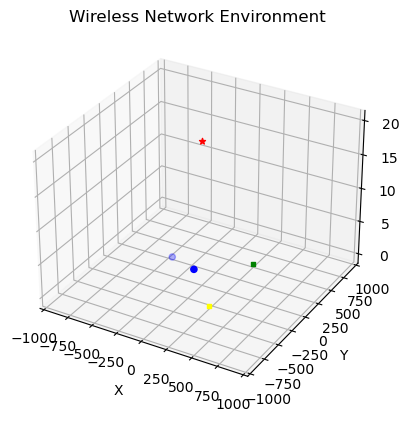

In [26]:

xt, yt, zt = BASE_STATION_POSITION
xs_1, ys_1, zs_1 = IRS_POSITION_1
xs_2, ys_2, zs_2 = IRS_POSITION_2


USER_POS = generate_user_positions_3D(K, GRID_RADIUS)
fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.scatter3D(USER_POS[:, 0], USER_POS[:, 1], color='blue', marker='o', label='Users')
ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
plt.scatter(xs_1, ys_1, zs_1, color='green', marker='s', label='IRS_1')
plt.scatter(xs_2, ys_2, zs_2, color='yellow', marker='s', label='IRS_2')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis([-1000,1000,-1000,1000])
ax.set_title('Wireless Network Environment')
# ax.legend()
ax.grid(True)

print('User positions:'"\n" , USER_POS)
print('BS position:'"\n" , BASE_STATION_POSITION)
print('IRS-1 position:'"\n" , IRS_POSITION_1)
print('IRS-2 position:'"\n" , IRS_POSITION_2)

loc_T = np.array([BASE_STATION_POSITION])
loc_U = USER_POS



Generating Fading Channels

In [12]:


h_dk_3d = np.zeros((NUM_SIMULATIONS,K,1), dtype= np.complex128)
h_rk1_3d = np.zeros((NUM_SIMULATIONS,Ns_max,K), dtype= np.complex128)
h_rk1_h_3d = np.zeros((NUM_SIMULATIONS,K,Ns_max), dtype= np.complex128)
G1_3d = np.zeros((NUM_SIMULATIONS,Ns_max,1), dtype= np.complex128)
h_rk2_3d = np.zeros((NUM_SIMULATIONS,Ns_max,K), dtype= np.complex128)
h_rk2_h_3d = np.zeros((NUM_SIMULATIONS,K,Ns_max), dtype= np.complex128) 
G2_3d = np.zeros((NUM_SIMULATIONS,Ns_max,1), dtype= np.complex128)



# Perform simulations
for i in range(NUM_SIMULATIONS):

    # Generate the Rayleigh Fading Channel for each user (h_dk)
    h_dk = np.zeros((K,1))
    h_dk = np.array(generate_rayleigh_fading_channel(K,FADING_STD_MEAN,FADING_STD_DEV))
    h_dk = np.reshape(h_dk ,(K,1))
    h_dk_3d[i] = h_dk
    
    # Generate the Nakagami Channel from each user to the IRS-1 (h_rk1)
    fading = []
    for user in range(K):
        fading.append(generate_nakagami_samples(m,omega,Ns_max)) 
    h_rk1 = fading
    h_rk1 = np.reshape(h_rk1,(Ns_max,K))
    h_rk1_transpose = np.transpose(h_rk1)
    h_rk1_h = np.conj(h_rk1_transpose)
    h_rk1_3d[i] = h_rk1
    h_rk1_h_3d[i] = h_rk1_h


    # Generate the Nakagami Channel from each user to the IRS-2 (h_rk2)
    fading = []
    for user in range(K):
        fading.append(generate_nakagami_samples(m,omega,Ns_max)) 
    h_rk2 = fading
    h_rk2 = np.reshape(h_rk2,(Ns_max,K))
    h_rk2_transpose = np.transpose(h_rk2)
    h_rk2_h = np.conj(h_rk2_transpose)
    h_rk2_3d[i] = h_rk2
    h_rk2_h_3d[i] = h_rk2_h

    # Generate the Nakagami Channel from base_station to the IRS-1 (G1)
    G1 = generate_nakagami_samples(m,omega,Ns_max) 
    G1 = np.reshape(G1,(Ns_max,1))
    G1_3d[i] = G1

    # Generate the Nakagami Channel from base_station to the IRS-2 (G2)
    G2 = generate_nakagami_samples(m,omega,Ns_max)
    G2 = np.reshape(G2,(Ns_max,1))
    G2_3d[i] = G2

print('Size of hdk3d', np.shape(h_dk_3d))
print('Size of hrk3d', np.shape(h_rk1_3d))
print('Size of hrkh3d', np.shape(h_rk1_h_3d))
print('Size of g3d', np.shape(G1_3d))



Size of hdk3d (10, 2, 1)
Size of hrk3d (10, 10, 2)
Size of hrkh3d (10, 2, 10)
Size of g3d (10, 10, 1)


Calculating Energy Efficiency for Ideal Discrete Model 

Getting Channels per Simulation

In [13]:
h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
G1_ns_values = [G1_3d[s][:Ns_max, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
G2_ns_values = [G2_3d[s][:Ns_max, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
h_rk1_ns_values = [h_rk1_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
h_rk2_ns_values = [h_rk2_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)    
h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns_max] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)

In [8]:
nIRSrow = int(np.sqrt(Ns_max))
nIRScol = nIRSrow
   
irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S_2 = irs_coords_2
        # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
        # print()
        
dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        

test

In [9]:
RATE_THRESHOLD = 10
arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))
EE = np.zeros((NUM_SIMULATIONS,1))

nIRSrow = int(np.sqrt(Ns_max))
nIRScol = nIRSrow
   
irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
loc_S_2 = irs_coords_2
        # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
        # print()
        
dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
        # Reshapiing the distance from antennas/BS to user
dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
dTS_1 = np.mean(dTS_1)
    # Compute row-wise averages
dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
dSU_2 = dSU_2.reshape(1,K)
        # Compute the sum of elements in each row
dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
dTS_2 = np.mean(dTS_2)

for s in range(NUM_SIMULATIONS):
    h_dk = h_dk_3d[s]  # Shape: (Ns, K)

    h_rk1= h_rk1_ns_values[s]
    h_rk1_h = h_rk1_h_ns_values[s] 
    G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

    h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
    h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
    G_2 = G2_ns_values[s]
    
    inc = int(Ns_max / K)
    theta_n = np.zeros((K, inc), dtype=complex)

    # nearest_quantized_theta = np.zeros((K, inc), dtype=complex)
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**2, 1) / (2**2)) - np.pi)

    theta_1 = theta_matrix_ideal(0, h_dk= None , h_rk= h_rk1, g= G_1, K= K, Ns= Ns_max, quantized_theta_set= quantized_theta_set)
    theta_2 = theta_matrix_ideal(0, h_dk= None , h_rk= h_rk2, g= G_2, K= K, Ns= Ns_max, quantized_theta_set= quantized_theta_set)
    results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns_max)
    results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns_max)
    arr_link_budget = np.zeros((K,1))

    for m in range (K):
        arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA)))  + (results_array_2[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_2**BETA)))))
        arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
        arr_SNR_disc[i,m,:] = compute_SNR(arr_link_budget[m],noise)
        arr_rate_disc[i,m,:] = compute_rate(arr_SNR_disc[i,m,:]) * BW
        outage_probability_disc[i,m,:] = compute_outage_probability(K, arr_rate_disc[i,m,:], RATE_THRESHOLD)
    arr_sumrate_disc[i] = (np.sum(arr_rate_disc[i,:,:]))
print(arr_sumrate_disc)
    # # Initialize an empty list to store theta_n values for each i
    # theta_n_values_complex = []
    # inc = int(Ns_max / K)
    # quantized_theta_n_values_complex = []

    # theta_n_values_complex = []
    # inc = int(Ns_max / K)

    # for i in range(K):
    #     theta_n_i = []
    #     beta_n = []

    #     for j in range(inc * i, inc * (i + 1)):
    #         theta_n = -np.angle(h_rk1[j][i]) - np.angle(G_1[j][0])

    #         # Adjust theta_n to lie within the range (-π, π)
    #         theta_n = (theta_n + np.pi) % (2 * np.pi) - np.pi

    #         # Find the nearest quantized theta value
    #         nearest_quantized_theta_new = quantized_theta_set[np.argmin(np.abs(theta_n - quantized_theta_set))]
    #         theta_n_i.append(nearest_quantized_theta_new)

    #         beta_theta_n = ((1 - B_min) * ((np.sin(nearest_quantized_theta_new - phi) + 1) / 2) ** a + B_min)
    #         beta_n.append(beta_theta_n)

    #     theta_n_values_complex.append(np.array(beta_n) * np.exp(1j * np.array(theta_n_i)))

    # theta_n_values_complex = np.array(theta_n_values_complex)
    # print(theta_n_values_complex)

[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [8.20986749e+08]]


In [10]:
inc = int (Ns_max/K)
B = np.zeros((K,inc))
v = np.zeros((K,inc),dtype=np.complex128)
nearest_quantized_theta = np.zeros((K,inc))

# print(quantized_theta_set)


for s in range(NUM_SIMULATIONS):
    h_dk = h_dk_3d[s]  # Shape: (Ns, K)
    h_rk1= h_rk1_ns_values[s]
    G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
    inc = int(Ns_max / K)
    theta_n = np.zeros((K, inc), dtype=complex)
    nearest_quantized_theta = np.zeros((K, inc), dtype=complex)

for m in range(K):
    for n in range(inc):
        theta_n[m] = wrapToPi(- (np.angle(h_rk1[m*inc:(m+1)*inc, m]) + np.angle(G_1[m*inc:(m+1)*inc, 0])))
        nearest_quantized_theta[m][n] = quantized_theta_set[np.argmin(np.abs(theta_n[m][n] - quantized_theta_set))]
        B[m] = ((1 - B_min) * ((np.sin(nearest_quantized_theta[m] - phi) + 1) / 2) ** a + B_min)
        v[m] = B[m] * np.exp(1j*nearest_quantized_theta[m])
        # nearest_quantized_theta[m][n] = quantized_theta_set[np.argmin(np.abs(theta_n[m][n] - quantized_theta_set))]
    
    # nearest_quantized_theta_new = quantized_theta_set[np.argmin(np.abs(theta_n[:, np.newaxis] - quantized_theta_set), axis=1)]
# print(theta_n)
# print()

theta = np.zeros((K,inc,inc), dtype= np.complex128)

for m in range(K):
    row_val = v[m,:]
    for n in range(inc):
        theta[m,n,n] = row_val[n]

prod_f_theta = np.zeros((K,inc), dtype=np.complex128)
prod_fgtheta = np.zeros((K,1),dtype=np.complex128)
for m in range (K):
        prod_f_theta[m,:] = np.matmul(h_rk1_h[m,m*inc:(m+1)*inc],theta[m,:,:]) #multiplying each row with row of diagnol (one theta per user)
        prod_fgtheta = np.matmul(prod_f_theta,G_1[m*inc:(m+1)*inc, 0])
prod_fgtheta = np.reshape (prod_fgtheta, (K,1))
print(prod_fgtheta)

[[-9.48469728 +3.15250099j]
 [-8.28020352-11.59851495j]]


C:\Users\Ansar Raza\AppData\Local\Temp\ipykernel_17080\1594845760.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  B[m] = ((1 - B_min) * ((np.sin(nearest_quantized_theta[m] - phi) + 1) / 2) ** a + B_min)


In [6]:
inc = int (Ns_max/K)
theta_i = np.zeros((K,Ns_max))
theta_n = np.zeros((K,inc))


for s in range(NUM_SIMULATIONS):
    h_dk = h_dk_3d[s]  # Shape: (Ns, K)
    h_rk1= h_rk1_ns_values[s]
    G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
    inc = int(Ns_max / K)
    theta_n = np.zeros((K, inc), dtype=complex)

for m in range(K):
    theta_n[m] = wrapToPi(-(np.angle(h_rk1[m*inc:(m+1)*inc, m]) + np.angle(G_1[m*inc:(m+1)*inc, 0])))
    
    # nearest_quantized_theta_new = quantized_theta_set[np.argmin(np.abs(theta_n[:, np.newaxis] - quantized_theta_set), axis=1)]
phi_complex = 1 * np.exp(1j * theta_n)
print(phi_complex)
theta = np.zeros((K,inc,inc), dtype= np.complex128)
row_val = []
for m in range(K):
    row_val = phi_complex[m,:]
    for n in range(inc):
        theta[m,n,n] = row_val[n] 
print(theta)
            

[[-0.81938529+0.57324318j  0.6830812 +0.73034244j  0.85417073-0.51999266j
   0.42481737-0.90527907j -0.47568629+0.879615j   -0.46907865+0.8831564j
   0.9858467 +0.1676493j   0.89851766-0.43893738j -0.93797031-0.3467156j
   0.71545752-0.69865623j  0.32663144-0.94515179j -0.77299554-0.63441146j
   0.9341215 -0.35695521j -0.2431583 +0.96998662j -0.75951674+0.65048776j
   0.99182465+0.12760825j  0.91034595+0.41384809j -0.25942039-0.9657645j
   0.93057146-0.36611031j -0.06760917-0.99771188j -0.78318698+0.62178626j
  -0.9974375 -0.07154324j -0.99992965-0.01186166j -0.99616887+0.08745041j
   0.79599794+0.60529933j  0.28664361+0.95803729j -0.18019142-0.98363156j
  -0.4558088 -0.89007772j  0.43649594-0.89970622j  0.98210699+0.1883238j
   0.94220561+0.3350352j   0.99761017+0.06909371j -0.41137897+0.9114644j
   0.99441254-0.10556376j -0.12806843-0.99176533j -0.75454734+0.65624562j
  -0.78358078+0.62128992j -0.1197205 +0.99280764j  0.60065206-0.79951054j
   0.36259861+0.93194541j  0.22006509+0.975

In [12]:
inc = int (Ns_max/K)
# theta_i = np.zeros((K,Ns_max))
# theta_n = np.zeros((K,inc))


for s in range(NUM_SIMULATIONS):
    h_dk = h_dk_3d[s]  # Shape: (Ns, K)
    h_rk1= h_rk1_ns_values[s]
    G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

    # Initialize an empty list to store theta_n values for each i
    theta_n_values_complex = []
    inc = int(Ns_max / K)

    for i in range(K):
        theta_n_i = []

        for j in range(i * inc, (i + 1) * inc):
            theta_n = -np.angle(h_rk1[j][i]) - np.angle(G_1[j][0])

            # Adjust theta_n to lie within the range (-π, π)
            theta_n = (theta_n + np.pi) % (2 * np.pi) - np.pi

            # Find the nearest quantized theta value
            nearest_quantized_theta_new = quantized_theta_set[np.argmin(np.abs(theta_n - quantized_theta_set))]
            theta_n_i.append(nearest_quantized_theta_new)

        theta_n_values_complex.append(1 * np.exp(1j * np.array(theta_n_i)))

    theta_n_values_complex = np.array(theta_n_values_complex)
print(theta_n_values_complex)
                

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
inc = int (Ns_max/K)
theta_i = np.zeros((K,Ns_max))
theta_n = np.zeros((K,inc))


for s in range(NUM_SIMULATIONS):
    h_dk = h_dk_3d[s]  # Shape: (Ns, K)
    h_rk1= h_rk1_ns_values[s]
    G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
    for m in range(K):
            count = 0
            for n in range ((m*inc),(inc*(m+1))):
                theta_i[m][n] = wrapToPi(-((np.angle(h_rk1[n][m])) + (np.angle(G1[n]))))
                # count += 1
                if (count == inc):
                    theta_n[m,:] = theta_i[:, :inc]
                if (count == Ns_max):
                    theta_n[m,:] = theta_i[:, inc:]
                # print('b1:',m*int(Ns_max/K))
    
                # # print('b2',(int(Ns_max/K)*(m+1)))

                
                # if (count % (Ns_max/K) == 0):
                #     print('buh')
                #     continue 
      
    phi_complex = 1*np.exp(1j*theta_i)  
print(phi_complex) 
            

[[ 0.52188797-0.85301404j  0.98346853+0.18107913j  0.34568569+0.93835036j
  -0.46351707+0.88608799j  0.51210515+0.85892276j  1.        +0.j
   1.        +0.j          1.        +0.j          1.        +0.j
   1.        +0.j        ]
 [ 1.        +0.j          1.        +0.j          1.        +0.j
   1.        +0.j          1.        +0.j          0.79153483+0.61112406j
   0.90665556+0.42187165j  0.93020138+0.36704957j  0.63884485+0.76933559j
  -0.03821413+0.99926957j]]


In [ ]:

count = 0
K = 2
Ns_max = 10
inc = int(Ns_max / K)
B = 2
for s in range(NUM_SIMULATIONS):
    h_dk = h_dk_3d[s]  # Shape: (Ns, K)
    h_rk1= h_rk1_ns_values[s]
    G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

    # Initialize an empty list to store theta_n values for each i
    theta_n_values_complex = []
    inc = int(Ns_max / K)

    for m in range(K):
        theta_n_i = []
        for j in range(m * inc, (m + 1) * inc):
            theta_n = wrapToPi( - ((np.angle(h_rk1[j][m])) + (np.angle(G1[j]))))
            theta_n_i.append(theta_n)
        print(np.shape(theta_n_i))
        theta_n_values_complex.append(1 * np.exp(1j * np.array(theta_n_i)))

print(theta_n_values_complex)

(5, 1)
(5, 1)
[array([[ 0.52188797-0.85301404j],
       [ 0.98346853+0.18107913j],
       [ 0.34568569+0.93835036j],
       [-0.46351707+0.88608799j],
       [ 0.51210515+0.85892276j]]), array([[ 0.79153483+0.61112406j],
       [ 0.90665556+0.42187165j],
       [ 0.93020138+0.36704957j],
       [ 0.63884485+0.76933559j],
       [-0.03821413+0.99926957j]])]


Simulating for different Quantization bits

Ideal Continuous Case Double IRS

In [22]:
RATE_THRESHOLD = 10
qB = np.arange(2,4,1)
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(2, Ns_max_sqrt + 1)])
print(N_values)


arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))
avg_EE = np.zeros((len(N_values), 1))



    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

for B in qB:
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    average_energy_efficiency_1 = []
    sum_rates_1 = []

    for Ns in N_values:
        nIRSrow = int(np.sqrt(Ns))
        nIRScol = nIRSrow
# -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
        irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_2 = irs_coords_2
        # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
        # print()
        
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
        # Compute row-wise averages
        dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
        h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []

        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

            h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
            h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
            G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_ideal(1, h_dk= None , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, quantized_theta_set= None)
            theta_2 = theta_matrix_ideal(1, h_dk= None , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, quantized_theta_set= None)

            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
            results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)

        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA)))  + (results_array_2[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_2**BETA)))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
            print('For N:', Ns, 'Sum rate:', arr_sumrate_disc) 

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            # Compute the energy_efficiency
            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/10e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)

        # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
        # Compute average energy efficiency for the current N
        # avg_EE[Ns,0] = compute_average_energy_efficiency(EE)   
        # Append sum-rate for this T to the list
        # sum_rates_1.append((np.sum(sum_rate)/NUM_SIMULATIONS))
    
    # Store the results in the dictionary with N as the key
    # results_dict_1[B] = sum_rates_1
    
    # Store the results in the dictionary with N as the key
    results_dict_2[B] = average_energy_efficiency_1

# # print(EE)
# print('done')
# print(N_values)

[4 9]
For N: 4 Sum rate: [[9.51916878e+08]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
For N: 4 Sum rate: [[9.51916878e+08]
 [6.16736721e+08]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
For N: 4 Sum rate: [[9.51916878e+08]
 [6.16736721e+08]
 [6.93442580e+08]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
For N: 4 Sum rate: [[9.51916878e+08]
 [6.16736721e+08]
 [6.93442580e+08]
 [7.96767298e+08]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]
For N: 4 Sum rate: [[9.51916878e+08]
 [6.16736721e+08]
 [6.93442580e+08]
 [7.96767298e+08]
 [5.82989305e+08]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e

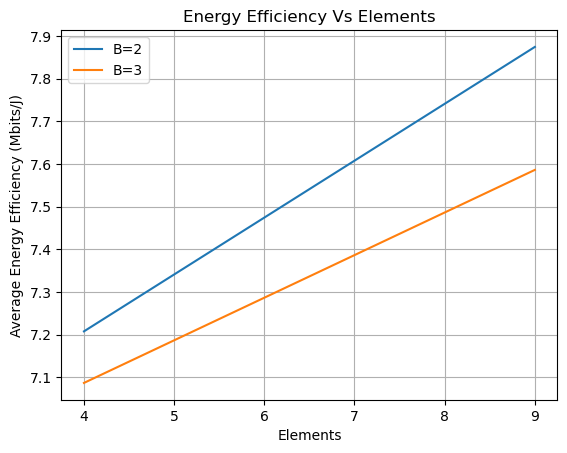

In [15]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(N_values, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('Elements')
plt.title('Energy Efficiency Vs Elements')
plt.legend()
plt.grid(True)
plt.show()



Practical Discrete Case Double IRS

In [16]:
RATE_THRESHOLD = 10
qB = np.arange(2,4,1)
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(2, Ns_max_sqrt + 1)])
print(N_values)


arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))
avg_EE = np.zeros((len(N_values), 1))



    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

for B in qB:
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    average_energy_efficiency_1 = []
    sum_rates_1 = []

    for Ns in N_values:
        nIRSrow = int(np.sqrt(Ns))
        nIRScol = nIRSrow
# -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
        irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_2 = irs_coords_2
        # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
        # print()
        
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
        # Compute row-wise averages
        dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
        h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []

        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

            h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
            h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
            G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_practical(0, h_dk= None , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set)
            theta_2 = theta_matrix_practical(0, h_dk= None , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )

            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
            results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)

        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA)))  + (results_array_2[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_2**BETA)))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            # Compute the energy_efficiency
            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/10e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)

        # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


    
    # Store the results in the dictionary with N as the key
    results_dict_2[B] = average_energy_efficiency_1
print(arr_sumrate_disc) 
# # print(EE)
# print('done')
# print(N_values)

[4 9]
[[8.28124175e+08]
 [6.60741612e+08]
 [7.46207478e+08]
 [6.82271810e+08]
 [6.52067449e+08]
 [1.05627617e+09]
 [5.84341172e+08]
 [8.24431631e+08]
 [6.11695039e+08]
 [5.47251731e+08]]


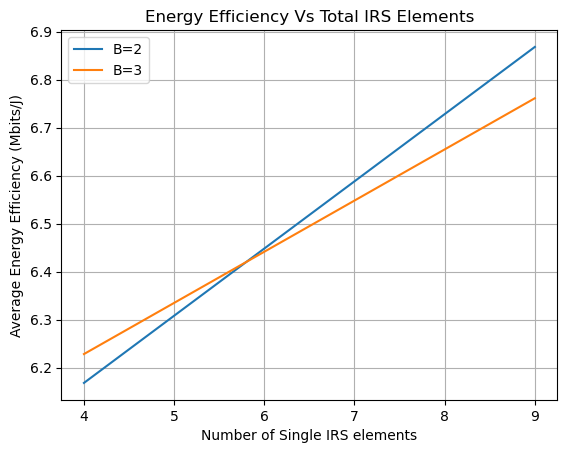

In [17]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(N_values, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('Number of Single IRS elements')
plt.title('Energy Efficiency Vs Total IRS Elements')
plt.legend()
plt.grid(True)
plt.show()


# SINGLE IRS CASE

User positions:
 [[-779.35284967  264.02173041    0.        ]
 [ -18.56945811   -6.62731693    0.        ]]
BS position:
 (0, 0, 20)
IRS-1 position:
 (300, 400, 10)


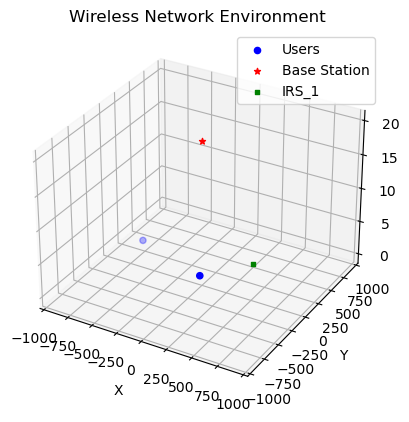

In [ ]:

xt, yt, zt = BASE_STATION_POSITION
xs_1, ys_1, zs_1 = IRS_POSITION_1

fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.scatter3D(USER_POS[:, 0], USER_POS[:, 1], color='blue', marker='o', label='Users')
ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
plt.scatter(xs_1, ys_1, zs_1, color='green', marker='s', label='IRS_1')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis([-1000,1000,-1000,1000])
ax.set_title('Wireless Network Environment')
plt.legend()
# ax.legend()
ax.grid(True)

print('User positions:'"\n" , USER_POS)
print('BS position:'"\n" , BASE_STATION_POSITION)
print('IRS-1 position:'"\n" , IRS_POSITION_1)

loc_T = np.array([BASE_STATION_POSITION])
loc_U = USER_POS



In [ ]:
h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

# BS to IRS
G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

# IRS to Users
h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)


Ideal Continuous Case Single IRS

In [ ]:
RATE_THRESHOLD = 10
qB = np.arange(2,4,1)
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(2, Ns_max_sqrt + 1)])
print(N_values)


arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))
avg_EE = np.zeros((len(N_values), 1))



    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

for B in qB:
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    average_energy_efficiency_1 = []
    sum_rates_1 = []

    for Ns in N_values:
        nIRSrow = int(np.sqrt(Ns))
        nIRScol = nIRSrow
# -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
        irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_2 = irs_coords_2
        # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
        # print()
        
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
        # Compute row-wise averages
        dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
        h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []

        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_ideal(1, h_dk= None , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, quantized_theta_set= None)
            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)

        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA)))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            # Compute the energy_efficiency
            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/10e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)

        # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    
    # Store the results in the dictionary with N as the key
    results_dict_2[B] = average_energy_efficiency_1

print('done')
print(N_values)

[  4   9  16  25  36  49  64  81 100]


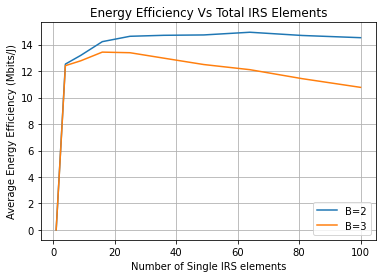

In [ ]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(N_values, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('Number of Single IRS elements')
plt.title('Energy Efficiency Vs Total IRS Elements')
plt.legend()
plt.grid(True)
plt.show()

# # Plot the graph for each value of N
# for B, sum_rates_1 in results_dict_1.items():
#     plt.plot(N_values, sum_rates_1, label=f'B={B}')

# plt.ylabel('Sum rate')
# plt.xlabel('Number of IRS elements')
# plt.title('Sum Rates Vs IRS Elements')
# plt.legend()
# plt.grid(True)
# plt.show()

# SINGLE IRS CASE

User positions:
 [[-395.93163393  147.24490335    0.        ]
 [-118.88219567   61.17405494    0.        ]]
BS position:
 (0, 0, 20)
IRS-1 position:
 (300, 400, 10)


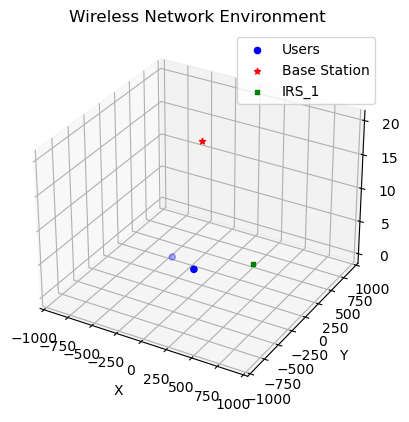

In [18]:
# Plot the 3D grid, base station, IRS, and user positions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
ax.scatter(IRS_POSITION_1[0], IRS_POSITION_1[1], IRS_POSITION_1[2], color='green', marker='s', label='IRS')
ax.scatter(user_positions[:, 0], user_positions[:, 1], color='blue', marker='o', label='User')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Wireless Network Environment')
ax.legend()
ax.grid(True)

print('User positions:'"\n" , USER_POS)
print('BS position:'"\n" , BASE_STATION_POSITION)
print('IRS-1 position:'"\n" , IRS_POSITION_1)

loc_T = np.array([BASE_STATION_POSITION])
loc_U = USER_POS



In [19]:
h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

# BS to IRS
G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

# IRS to Users
h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)


Ideal Continuous Case Single IRS

In [20]:
qB = np.arange(2,4,1)
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(1, Ns_max_sqrt + 1)])
print(N_values)

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}

for B in qB:
    
    average_energy_efficiency_1 = []
    sum_rates_1 = []

    for Ns in N_values:
        nIRSrow = int(np.sqrt(Ns))
        nIRScol = nIRSrow

        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
        
        # Extract channel values for the current Ns value
        h_rk2_h_ns_values = [h_rk_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        G1_ns_values = [G_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # Initialize list to store individual outage probabilities
        energy_efficiency = []
        
        # Initialize sum-rates for this case
        sum_rate = []
    
        # Perform simulations
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s]  # Shape: (1, K)
            h_rk1 = h_rk2_h_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = np.transpose(np.conj(h_rk1))  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
            
            results_array = results_array_sharing_ideal(K, Ns, Nt, h_rk1, h_rk1_h, G_1, B)
            
            link_inter = []
            
            for m in range(K):
                link_inter_value = (TRANSMIT_POWER_WATTS)**0.5 * (((h_dk[0][m]*0)/(np.sqrt((dTU[0][m])**ZETA))) + ((results_array[0][m])/(np.sqrt((dSU_1[0][m])**ALPHA * (dTS_1)**ALPHA))))
                link_inter.append(link_inter_value)  # Append the computed value to the list
            
            # Convert the list to a numpy array
            link_inter = np.array(np.abs(link_inter))
            link_inter_array = link_inter.reshape(1,K)
            
            # Calculate link_budget using the updated link_inter array
            link_budget = 10 * np.log10((link_inter_array)**2) + 30 
            link_budget = link_budget.reshape(1,K)
            # print(link_budget)
            
            #Calculate the noise value
            # noise = -133 # in dBm
            
            SNR_matrix = []
            
            # Calculate SNR
            for m in range(K):
                SNR = compute_SNR(link_budget[0][m], noise)
                SNR_matrix.append(SNR)
            
            SNR_matrix = np.array(SNR_matrix)
            SNR_matrix = SNR_matrix.reshape(1,K)
            
            # Calculate rate 
            rate_matrix = BW * compute_rate((SNR_matrix))
            rate_matrix_new = rate_matrix.flatten()
            sum_rate_N = np.sum(rate_matrix_new)
            sum_rate.append(sum_rate_N)
            # print(sum_rate_N)
            
            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_2 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_2 + power_3

            # Compute the energy_efficiency
            ee = compute_energy_efficiency(sum_rate_N, P)
            energy_efficiency.append(ee/10e6)
    
        # Compute average energy efficiency for the current N
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)
        
        # Append sum-rate for this T to the list
        sum_rates_1.append((np.sum(sum_rate)/NUM_SIMULATIONS))
        
    # Store the results in the dictionary with N as the key
    results_dict_1[B] = sum_rates_1

        # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

print(arr_sumrate_disc)
    
# Store the results in the dictionary with N as the key
results_dict_2[B] = average_energy_efficiency_1

print('done')
print(N_values)

IndentationError: unexpected indent (2280901018.py, line 129)

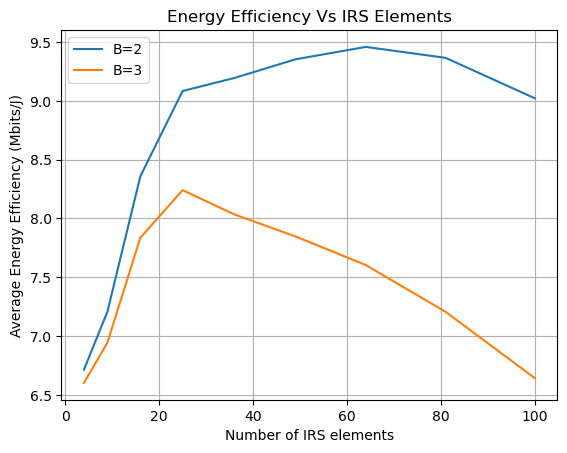

In [ ]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(N_values, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('Number of IRS elements')
plt.title('Energy Efficiency Vs IRS Elements')
plt.legend()
plt.grid(True)
plt.show()

# # Plot the graph for each value of N
# for B, sum_rates_1 in results_dict_1.items():
#     plt.plot(N_values, sum_rates_1, label=f'B={B}')

# plt.ylabel('Sum rate (kbps)')
# plt.xlabel('Number of IRS elements')
# plt.title('Sum Rates Vs IRS Elements')
# plt.legend()
# plt.grid(True)
# plt.show()

Practical Discrete Case Single IRS

In [ ]:
RATE_THRESHOLD = 10
qB = np.arange(2,4,1)
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(2, Ns_max_sqrt + 1)])
print(N_values)


arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))
avg_EE = np.zeros((len(N_values), 1))



    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

for B in qB:
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    average_energy_efficiency_1 = []
    sum_rates_1 = []

    for Ns in N_values:
        nIRSrow = int(np.sqrt(Ns))
        nIRScol = nIRSrow
# -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
        irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_2 = irs_coords_2
        # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
        # print()
        
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
        # Compute row-wise averages
        dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
        G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk2_ns_values = [h_rk2_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
        h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []

        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_practical(0, h_dk= None , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set)
            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)

        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA)))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            # Compute the energy_efficiency
            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/10e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)

        # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    
    # Store the results in the dictionary with N as the key
    results_dict_2[B] = average_energy_efficiency_1

print('done')
print(N_values)

        # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Store the results in the dictionary with N as the key
    results_dict_2[B] = average_energy_efficiency_1

print(arr_sumrate_disc)
# # print(EE)
# print('done')
# print(N_values)

[  4   9  16  25  36  49  64  81 100]


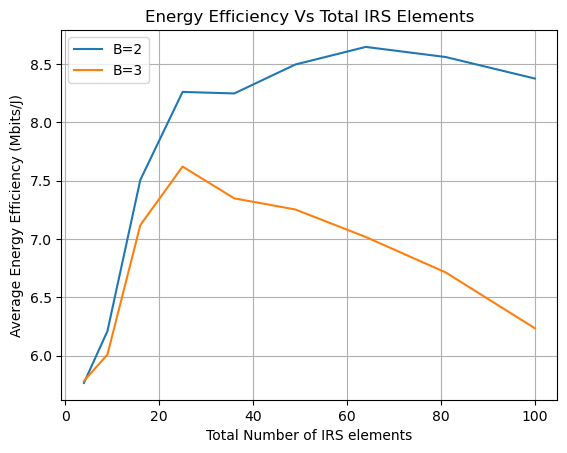

In [ ]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(N_values, average_energy_efficiency_1, label=f'B={B}')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('Total Number of IRS elements')
plt.title('Energy Efficiency Vs Total IRS Elements')
plt.legend()
plt.grid(True)
plt.show()

# # Plot the graph for each value of N
# for B, sum_rates_1 in results_dict_1.items():
#     plt.plot(N_values, sum_rates_1, label=f'B={B}')

# plt.ylabel('Sum rate')
# plt.xlabel('Number of IRS elements')
# plt.title('Sum Rates Vs IRS Elements')
# plt.legend()
# plt.grid(True)
# plt.show()